# Finetuning a ResNet

Modern deep convnets tend to have tens (if not hundreds) of layers, with millions (if not tens of millions) of trainable parameters. More often than not several of these layers have skipped connections; the *ResNet* family of networks are an example. 

The flip side of having such deep network architectures is that to properly learn such networks, one requires *massive* amounts of training data. In most applications, access to such massive datasets simply isn't available; gathering and curating a dataset with a few hundred/thousand examples itself can be a challenge.

What should one do in the ``small data'' setting? A possible solution:
* start with a deep network architecture initialized with *pre-trained* weights, and
* *fine-tune* the network weights on the (small) training dataset.

In this demo we will see how to train a simple cat-vs-dog classifier using a very small training dataset of 60 images. The dataset is provided [here](https://github.com/chinmayhegde/dl-demos/blob/main/data.zip). You can unzip and save the dataset anywhere you like; I've saved it to my Google drive folder: `MyDrive\data`.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [3]:

# data transforms
dset_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])])


# Use the image folder function to create datasets
dsets = {x: datasets.ImageFolder(f"./data/{x}", dset_transform)
         for x in ['train', 'val']}

# create data loader
dataloaders = {x: torch.utils.data.DataLoader(dsets[x], batch_size=16,
                                              shuffle=(x == "train"))
               for x in ['train', 'val']}


# Loading a pre-trained ResNet model

Let's load a ResNet34 model from `torchvision` and examine it.

In [4]:
# intialize model
model = models.resnet34(pretrained=True)

In [5]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Hmm, lots of layers. Each `BasicBlock` is two or three conv layers with a skipped connection, with batch-norm layers thrown in for good measure. Several such residual blocks are pieced together, and in the end there is a dense layer with 1000 output neurons. This model has been trained on the well-known *ImageNet* dataset (which has over a million images with 1000 classes). As an aside, let's examine the number of trainable parameters in the model.

In [6]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

21797672


Let us finetune this model for our cat-vs-dog classification problem. Since this is a binary classifier we will redefine the output (linear) layer to have 2 outputs.

In [7]:
num_ftrs = model.fc.in_features
print(num_ftrs)

512


In [8]:
model.fc = nn.Linear(num_ftrs, 2)

In [9]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Observe now that the basic ResNet34 backbone remains the same; only the output layer has changed. In fact, all of the weights (except the output layer) also have been retained.  

Let's do a quick model evaluation to check if there are any errors thrown during prediction.

In [10]:
model.eval()
corrects = 0
for batch_idx, (inputs,labels) in enumerate(dataloaders['val'], 1):
  with torch.set_grad_enabled(False):
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    
  corrects += torch.sum(preds == labels.data)

print(corrects.float() / len(dataloaders['val'].dataset))

tensor(0.5000)


As we can see, we get an accuracy of 50\% on the test set -- which is exactly what we would expect since the weights of the output layer are random. 

We are now ready to start fine-tuning! The rest of the code below is boilerplate training; we see below that only a few epochs are enough to tune the weights to our training dataset.  

In [11]:
# define loss function, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
save_loss = {'train':[], 'val':[]}
save_acc = {'train':[], 'val':[]}

In [12]:
for epoch in range(5):

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        current_loss = 0.0
        current_corrects = 0

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase], 1):
            optimizer.zero_grad()

            # Time to carry out the forward training poss
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # We want variables to hold the loss/acc statistics
            current_loss += loss.item() * inputs.size(0)
            current_corrects += torch.sum(preds == labels.data)
        # saving variable for plottin
        save_loss[phase] += [current_loss / len(dataloaders[phase].dataset)]
        save_acc[phase] += [current_corrects.float() / len(dataloaders[phase].dataset)]

        # pretty print
        print(f"Epoch:{epoch} -- Phase:{phase} -- Loss:{save_loss[phase][-1]:.2f} -- Acc:{save_acc[phase][-1]*100:.2f}")


Epoch:0 -- Phase:train -- Loss:0.79 -- Acc:48.33
Epoch:0 -- Phase:val -- Loss:0.61 -- Acc:66.67
Epoch:1 -- Phase:train -- Loss:0.42 -- Acc:90.00
Epoch:1 -- Phase:val -- Loss:0.28 -- Acc:100.00
Epoch:2 -- Phase:train -- Loss:0.22 -- Acc:96.67
Epoch:2 -- Phase:val -- Loss:0.12 -- Acc:100.00
Epoch:3 -- Phase:train -- Loss:0.08 -- Acc:100.00
Epoch:3 -- Phase:val -- Loss:0.06 -- Acc:100.00
Epoch:4 -- Phase:train -- Loss:0.06 -- Acc:100.00
Epoch:4 -- Phase:val -- Loss:0.04 -- Acc:100.00


Text(0.5, 1.0, 'Accuracy')

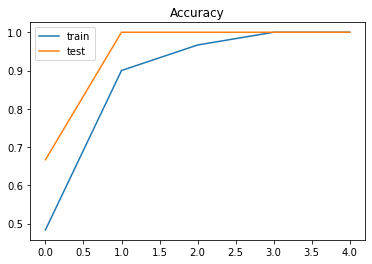

In [13]:
plt.plot(save_acc['train'])
plt.plot(save_acc['val'])
plt.legend(["train", "test"])
plt.title("Accuracy")


There we go! That took only 4 epochs of finetuning.

This was a very small dataset (of only 60 training images) so it is not that surprising that we were able to fit the data so easily. Try training your own classifier with a slightly larger set of data points, and see if you can get similar results.